This notebook is meant to navigate the manifold of an autoencoder along the iso potential of a scalar function. The function is in this example the score of a digit recognition model.

# Import and functions

In [71]:
import numpy as np
import tensorflow as tf
import time

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

from function import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare dataset

In [36]:
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10
N_train, N_valid, N_test = (30000, 3000, 3000)

In [37]:
x_train, y_train, x_valid, y_valid, x_test, y_test = get_data(N_train, N_valid, N_test)

('Successfully downloaded', 'train-images-idx3-ubyte.gz', 9912422L, 'bytes.')
('Successfully downloaded', 'train-labels-idx1-ubyte.gz', 28881L, 'bytes.')
('Successfully downloaded', 't10k-images-idx3-ubyte.gz', 1648877L, 'bytes.')
('Successfully downloaded', 't10k-labels-idx1-ubyte.gz', 4542L, 'bytes.')
('Extracting', 'data/train-images-idx3-ubyte.gz')
('Extracting', 'data/train-labels-idx1-ubyte.gz')
('Extracting', 'data/t10k-images-idx3-ubyte.gz')
('Extracting', 'data/t10k-labels-idx1-ubyte.gz')
Information on dataset
x_train (30000, 28, 28, 1)
y_train (30000,)
x_valid (3000, 28, 28, 1)
y_valid (3000,)
x_test (3000, 28, 28, 1)
y_test (3000,)


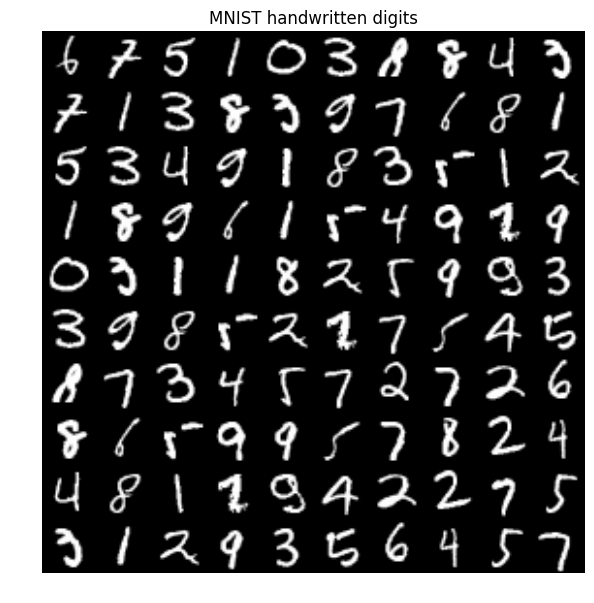

In [38]:
plot_random_mnist(x_test)

# Create computational graph

In [39]:
def init(sess, ae_architecture, learning_rate_ae=0.001, learning_rate_reco=0.01, learning_rate_lenet=0.01):
    transfer_fct = tf.nn.softplus

    # tf Graph input
    x = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS])
    y = tf.placeholder(tf.int64, [None, ])
    
    x_shape = tf.reshape(x, (-1, IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS))
    
    # Create variational autoencoder
    z, x_reconstr_mean, z_mean, z_log_sigma_sq, x_grad, z_grad = \
        create_autoencoder(x_shape, ae_architecture, transfer_fct)
        
    reconstr_error, encoder_obj, encoder_optimizer = \
        create_encoder_loss_optimizer(x_shape, x_reconstr_mean, z_mean, z_log_sigma_sq, learning_rate_ae)
    
    # Create recognition network (scalar function)
    z_input, scores_reco, loss_reco = create_recognition_network(y, ae_architecture["n_z"])
    reco_optimizer = create_recognition_loss_optimizer(scores_reco, loss_reco, learning_rate_reco)
    
    
    # Create classifier (from initial space)
    lenet_train_data_node, lenet_train_labels_node, lenet_logits, lenet_loss, lenet_optimizer, \
        lenet_eval_data, lenet_eval_labels, lenet_eval_score, lenet_eval_prediction, \
            lenet_eval_saliency_grad, lenet_train_prediction = create_classifier_network(learning_rate_lenet)

    # Initializing the tensor flow variables
    init = tf.initialize_all_variables()
    sess.run(init)
    encoder_info = (x, x_shape, y, z, x_reconstr_mean, reconstr_error, \
                        encoder_obj, encoder_optimizer, x_grad, z_grad)
    reco_info = (z_input, scores_reco, loss_reco, reco_optimizer)
    lenet_info = (lenet_train_data_node, lenet_train_labels_node, lenet_logits, lenet_loss, lenet_optimizer, \
        lenet_eval_data, lenet_eval_labels, lenet_eval_score, lenet_eval_prediction, \
            lenet_eval_saliency_grad, lenet_train_prediction)   
    return (encoder_info, reco_info, lenet_info)

In [40]:
def train_autoencoder(sess, batch_size=100, training_epochs=10, display_step=5):
    # Training cycle
    n_samples = x_train.shape[0]
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = x_train[i*batch_size:(i+1)*batch_size]

            # Fit training using batch data
            _, cost = sess.run((encoder_optimizer, encoder_obj), 
                                  feed_dict={x: batch_xs})
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost)
                
def train_recognition_model(sess, batch_size=100, training_epochs=10, display_step=5):
    # Training cycle
    n_samples = x_train.shape[0]
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = x_train[i*batch_size:(i+1)*batch_size]
            batch_ys = y_train[i*batch_size:(i+1)*batch_size]
            
            batch_zs = sess.run((z), feed_dict={x:batch_xs})
            # Fit training using batch data
            _, cost = sess.run((reco_optimizer, loss_reco), 
                                  feed_dict={z_input: batch_zs, y:batch_ys})
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost)    

def train_lenet_model(sess, batch_size=100, training_epochs=10):
    # Create a local session to run the training.
    EVAL_FREQUENCY = 100
    EVAL_BATCH_SIZE = 100
    train_size = N_train
    num_epochs = 10
    start_time = time.time()
    # Loop through training steps.
    def eval_in_batches(data, sess):
        """Get all predictions for a dataset by running it in small batches."""
        size = data.shape[0]
        if size < EVAL_BATCH_SIZE:
            raise ValueError("batch size for evals larger than dataset: %d" % size)
        predictions = np.ndarray(shape=(size, NUM_LABELS), dtype=np.float32)
        for begin in xrange(0, size, EVAL_BATCH_SIZE):
            end = begin + EVAL_BATCH_SIZE
            if end <= size:
                predictions[begin:end, :] = sess.run(lenet_eval_prediction,
                    feed_dict={lenet_eval_data: data[begin:end, ...]})
            else:
                batch_predictions = sess.run(
                    lenet_eval_prediction,
                    feed_dict={lenet_eval_data: data[-EVAL_BATCH_SIZE:, ...]})
                predictions[begin:, :] = batch_predictions[begin - size:, :]
        return predictions
    for step in xrange(int(num_epochs * train_size) // batch_size):
        # Compute the offset of the current minibatch in the data.
        # Note that we could use better randomization across epochs.
        offset = (step * batch_size) % (train_size - batch_size)
        batch_data = x_train[offset:(offset + batch_size)]
        batch_labels = y_train[offset:(offset + batch_size)]
        # This dictionary maps the batch data (as a numpy array) to the
        # node in the graph it should be fed to.
        feed_dict = {lenet_train_data_node: batch_data,
                   lenet_train_labels_node: batch_labels}
        # Run the graph and fetch some of the nodes.
        _, l, predictions = sess.run(
          [lenet_optimizer, lenet_loss, lenet_train_prediction],
          feed_dict=feed_dict)
        if step % EVAL_FREQUENCY == 0:
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print('Step %d (epoch %.2f), %.1f ms' %
                  (step, float(step) * batch_size / train_size,
                   1000 * elapsed_time / EVAL_FREQUENCY))
            print('Minibatch loss: %.3f' % l)
            print('Minibatch error: %.1f%%' % error_rate(predictions, batch_labels))
            print('Validation error: %.1f%%' % error_rate(
                eval_in_batches(x_valid, sess), y_valid))
            sys.stdout.flush()
    # Finally print the result!
    pred = eval_in_batches(x_test, sess)
    test_error = error_rate(pred, y_test)
    print('Test error: %.1f%%' % test_error)                

# Init graph

In [49]:
ae_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space
    
with tf.Session() as sess:
    (encoder_info, reco_info, lenet_info) = \
        init(sess, ae_architecture, learning_rate_ae=0.001)

    # taking care of the autoencoder
    x, x_shape, y, z, x_reconstr_mean, reconstr_error, \
        encoder_obj, encoder_optimizer, x_grad, z_grad = encoder_info
    print('Autoencoder Initialized!')
    
    # now for the recognition model
    # training 
    z_input, scores_reco, loss_reco, reco_optimizer = reco_info
    print('Recognition Model Initialized!')

    
    # then for the lecun
    lenet_train_data_node, lenet_train_labels_node, lenet_logits, lenet_loss, lenet_optimizer, \
        lenet_eval_data, lenet_eval_labels, lenet_eval_score, lenet_eval_prediction, \
            lenet_eval_saliency_grad, lenet_train_prediction = lenet_info
    print("LeNet Model Initialized!")
    
    # save the whole configuration
    save_path = tf.train.Saver().save(sess, "/tmp/multi_graph.ckpt")
    print("Model saved in file: %s" % save_path)

Autoencoder Initialized!
Recognition Model Initialized!
LeNet Model Initialized!
Model saved in file: /tmp/multi_graph.ckpt


# Training VAE

In [50]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    # Do some work with the model
    
    train_autoencoder(sess, training_epochs=20)
    print "Autoencoder is now learned \n"
    
    # save the whole configuration
    save_path = tf.train.Saver().save(sess, "/tmp/multi_graph.ckpt")
    print("Model saved in file: %s" % save_path)

Model restored.
Epoch: 0001 cost= 202.387891998
Epoch: 0006 cost= 120.034856389
Epoch: 0011 cost= 110.858457031
Epoch: 0016 cost= 107.579689407
Autoencoder is now learned 

Model saved in file: /tmp/multi_graph.ckpt


# Training Recognition

In [51]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    # Do some work with the model
    
    train_recognition_model(sess, training_epochs=10)
    z_test = sess.run([z], feed_dict={x:x_test})[0]
    y_pred = sess.run([scores_reco], feed_dict={z_input:z_test})[0]
    print "model on latent space gives", error_rate(y_pred, y_test), "% test error \n"
    
    # save the whole configuration
    save_path = tf.train.Saver().save(sess, "/tmp/multi_graph.ckpt")
    print("Model saved in file: %s" % save_path)

Model restored.
Epoch: 0001 cost= 0.920790128
Epoch: 0006 cost= 0.398737527
model on latent space gives 14.2333333333 % test error 

Model saved in file: /tmp/multi_graph.ckpt


# Training LeNet

In [52]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    # Do some work with the model
    
    train_lenet_model(sess, training_epochs=5)
    print "LeNet learned"

    
    # save the whole configuration
    save_path = tf.train.Saver().save(sess, "/tmp/multi_graph.ckpt")
    print("Model saved in file: %s" % save_path)

Model restored.
Step 0 (epoch 0.00), 3.6 ms
Minibatch loss: 6.913
Minibatch error: 93.0%
Validation error: 91.3%
Step 100 (epoch 0.33), 63.4 ms
Minibatch loss: 0.603
Minibatch error: 20.0%
Validation error: 8.3%
Step 200 (epoch 0.67), 57.9 ms
Minibatch loss: 0.258
Minibatch error: 8.0%
Validation error: 5.2%
Step 300 (epoch 1.00), 57.5 ms
Minibatch loss: 0.180
Minibatch error: 5.0%
Validation error: 4.6%
Step 400 (epoch 1.33), 57.4 ms
Minibatch loss: 0.246
Minibatch error: 7.0%
Validation error: 4.7%
Step 500 (epoch 1.67), 57.9 ms
Minibatch loss: 0.119
Minibatch error: 2.0%
Validation error: 3.6%
Step 600 (epoch 2.00), 57.6 ms
Minibatch loss: 0.123
Minibatch error: 3.0%
Validation error: 2.9%
Step 700 (epoch 2.33), 57.4 ms
Minibatch loss: 0.096
Minibatch error: 3.0%
Validation error: 3.7%
Step 800 (epoch 2.67), 59.0 ms
Minibatch loss: 0.057
Minibatch error: 1.0%
Validation error: 3.0%
Step 900 (epoch 3.00), 58.3 ms
Minibatch loss: 0.121
Minibatch error: 3.0%
Validation error: 2.8%
Step

# Visualize VAE
## Reconstruction

Model restored.


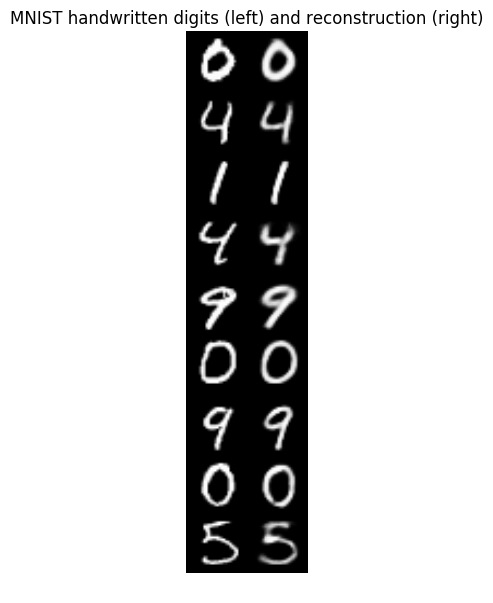

In [53]:
N = [3, 4, 5, 6, 9, 10, 12, 13, 15]
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    # Do some work with the model
    x_hat = sess.run([x_reconstr_mean], {x: x_test[N]})[0]
    
canvas = np.zeros((28*9, 2*28))
for i in range(9):
        canvas[i*28:(i+1)*28, :28] = x_test[N[i]].reshape((28, 28))
        canvas[i*28:(i+1)*28, 28:] = x_hat[i].reshape((28, 28))
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits (left) and reconstruction (right)')
plt.show()

## Generation check

Model restored.


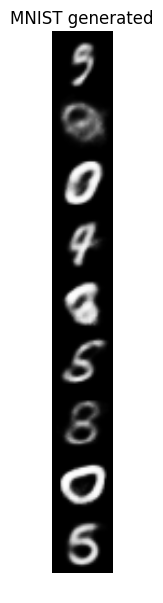

In [57]:
n = 9
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    # Do some work with the model
    input_latent = np.random.normal(size=(n, ae_architecture["n_z"]))
    x_hat = sess.run([x_reconstr_mean], {z: input_latent})[0]
    
canvas = np.zeros((28*9, 28))
for i in range(9):
        canvas[i*28:(i+1)*28, :28] = x_hat[i].reshape((28, 28))
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST generated')
plt.show()

## Fooling images

8


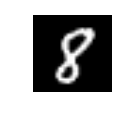

In [58]:
# choosing a great image
N=3

im = x_train[N, :, :, :]
lab = y_train[N]
print lab
plt.figure(figsize=(1, 1))
plt.axis('off')
plt.imshow(im[:, :, 0], cmap='gray')
plt.show()

In [59]:
target = 6
epsilon = 1e-3

## LeCun only based gradient ascent

Model restored.
Original: 8 Target: 6


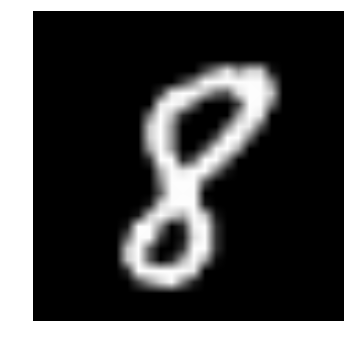

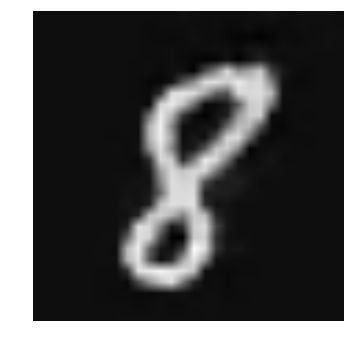

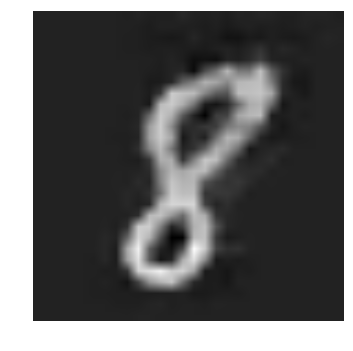

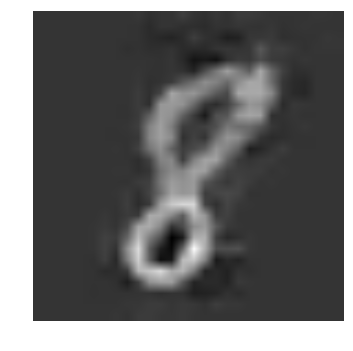

POriginal: 0.494887 PTarget: 0.505113


In [60]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    print "Original:", lab, "Target:", target
    image = np.array(im)
    for t in range(1000):
        # Do some work with the model
        feed_dic = {lenet_eval_data: image[np.newaxis, :], lenet_eval_labels:[target]}
        proba, grad_scores = sess.run([lenet_eval_prediction, lenet_eval_saliency_grad], feed_dict=feed_dic)
        image += epsilon * grad_scores[0]
        if t % 100 == 0:
            plt.clf()
            plt.axis('off')
            plt.imshow(image[:, :, 0], cmap='gray')
            plt.show()
        if proba[0, lab] < proba[0, target]:
            break

            
    print "POriginal:", proba[0, lab], "PTarget:", proba[0, target]

In [61]:
target = 6
epsilon = 1e-3

## LeCun + VAE manifold Gradient Ascent

Model restored.
Original: 8 Target: 6


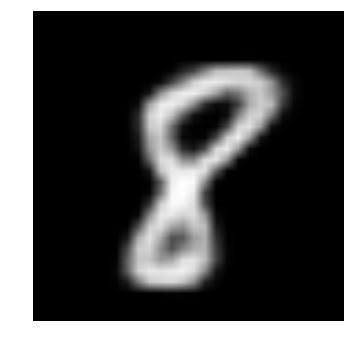

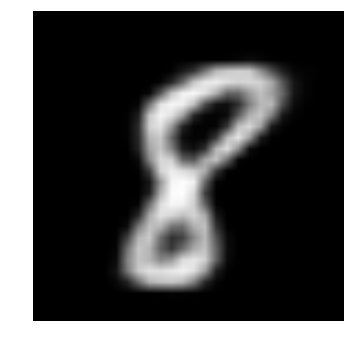

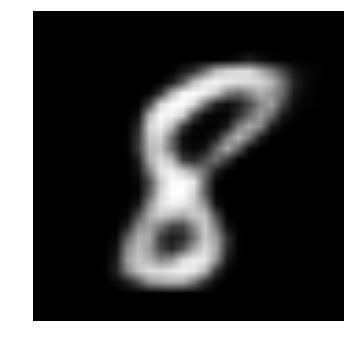

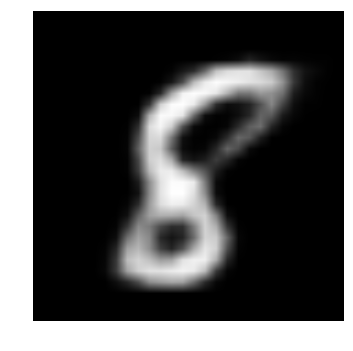

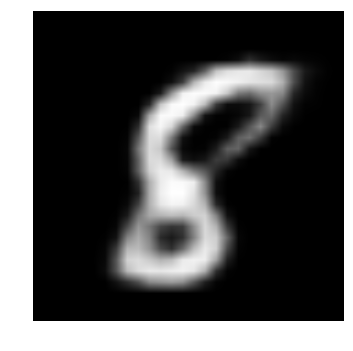

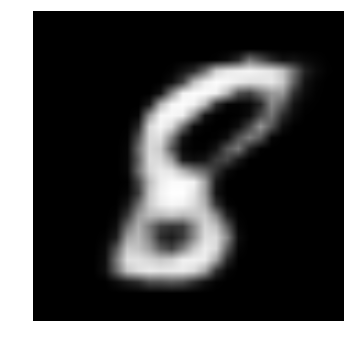

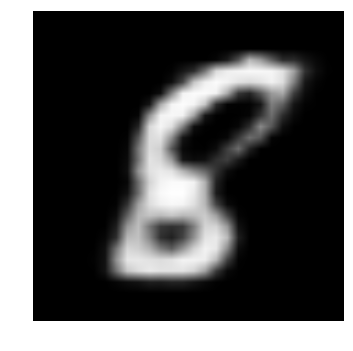

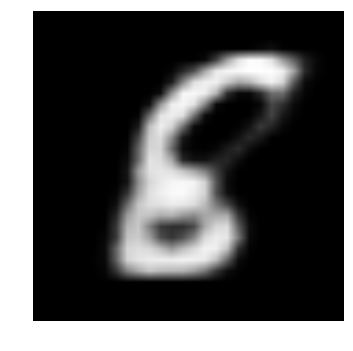

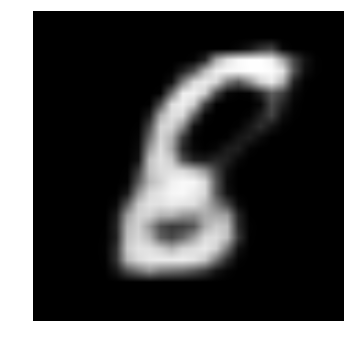

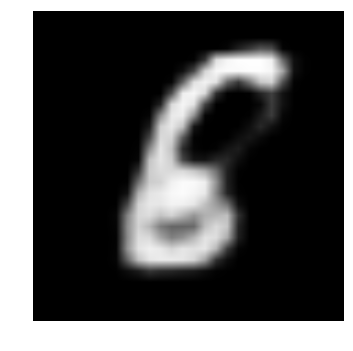

POriginal: 8.05538e-11 PTarget: 1.0


In [84]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/multi_graph.ckpt")
    print("Model restored.")
    print "Original:", lab, "Target:", target
    
    
    image = np.array(im)

    # compute local z as a starting point
    z_loc = sess.run([z], feed_dict={x:image[np.newaxis, :]})[0]

    for t in range(1000):    

        # prepare a new image
        image_rec = sess.run(x_reconstr_mean, feed_dict={z:z_loc})
        image_rec_sh = np.reshape(image_rec, (1, IMAGE_SIZE, IMAGE_SIZE, 1))
        # derive gradient of the functional given the image
        feed_dic = {lenet_eval_data: image_rec_sh, lenet_eval_labels:[target]}
        proba, grad_I = sess.run([lenet_eval_prediction, lenet_eval_saliency_grad], feed_dict=feed_dic)

        # get gradient on the manifold
        grad_I = np.reshape(grad_I, (1, 784))
        grad_z = sess.run(z_grad, feed_dict={x_grad:grad_I, x_reconstr_mean:image_rec, z:z_loc})[0]

        # navigate the manifold
        z_loc[0] += epsilon * grad_z[0]

        # plot a nice pic
        if t % 100 == 0:
            plt.clf()
            plt.axis('off')
            plt.imshow(image_rec_sh[0, :, :, 0], cmap='gray')
            plt.show()
        #if proba[0, lab] < proba[0, target]:
        #    break


print "POriginal:", proba[0, lab], "PTarget:", proba[0, target]